In [1]:
from pickle import load
import os
import torch
from utils import SimplexEnvironment

MDP = load(open(os.path.join("data", "mdps", "small" ,"small_mdp.bin"), 'rb'))
t = torch.from_numpy(MDP.get_transitions()).to(torch.float32)

100%|██████████| 10/10 [00:00<00:00, 5000.96it/s]


In [2]:
print( MDP.S, MDP.A, MDP.d)

100 10 3


We will use a Neural Network To approximate the embedding functions of our MDP.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
class Net(nn.Module): 
    def __init__(self, states, actions, d):
        super(Net, self).__init__()
        self.states = states
        self.actions = actions
        self.d = d
        self.device = 'cpu'
    
        self.l1 = nn.Linear(self.states + self.actions, 240)  #First Linear layers, Receives concat onehot enconding of state-action pair
        self.l2 = nn.Linear(240, 80)
        # self.bn1 = nn.BatchNorm1d(num_features=1)
        self.embedding = nn.Linear(80, self.d)
        init_params = torch.full((self.d, self.states), 1/self.states) + torch.rand((self.d, self.states))
        self.mu_weights = nn.Parameter(init_params)
    
    def to(self, device):
        self.device = device
        super(Net, self).to(device)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()


    def encode_input(self, s, a):
         """
        # Parameters:
        s: State id or list like of state ids between 0 and self.states
        a: Action id or list like of actions ids between 0 and self.actions

        If s and a are list-like, both need to be the same lenght
         """
         input_len = len(s) if hasattr(s, '__len__') else 1
         actions_len = len(a) if hasattr(a, '__len__') else 1
         assert input_len == actions_len, f"The input lenghts do not coincide. Input States: {input_len}; Input Actions: {actions_len}"

         s_hot = F.one_hot(s.view(input_len, 1), self.states).to(torch.float32)
         a_hot = F.one_hot(a.view(input_len, 1), self.actions).to(torch.float32)
         x = torch.cat((s_hot, a_hot), dim=-1)# Concat one hot vectors 
         return x.to(self.device)

    def enconde_output(self, s):
        input_len = len(s) if hasattr(s, '__len__') else 1
        return F.one_hot(s.view(input_len, 1), self.states).to(torch.float32)


    def phi(self, s, a):
        """
        # Parameters:
        s: State id or list like of state ids between 0 and self.states
        a: Action id or list like of actions ids between 0 and self.actions

        If s and a are list-like, both need to be the same lenght
         """
        
        x = self.encode_input(s, a) 
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        # x = self.bn1(x)
        x = F.softmax(self.embedding(x), dim=-1) # Apply softmax row wise

        return x # This should be of shape (batch_size, 1, d)

    def mu(self):
        return F.softmax(self.mu_weights, dim=-1)

    def forward(self, s, a):
        """
        # Parameters:
        s: State id or list like of state ids between 0 and self.states
        a: Action id or list like of actions ids between 0 and self.actions

        If s and a are list-like, both need to be the same lenght
        """
        x = self.phi(s, a)
        soft_mu = self.mu()

        # We use bradcasting in here so the same parameters are used for every element of the batch
        x = torch.matmul(x, soft_mu) # Mat multiplication of (batch_size, 1, d) @ (d, states) --> (batch_size, 1, states) # Distribution over states

        return x.view(-1, self.states)

    def phi_a_matrix(self, a):
        """Calculates the transition kernes induces by phi when one action a is fixed.
        # Parameters:
        a: Action id between 0 and self.actions - 1
         """
        actions_list = a.repeat(self.states)
        state_list = torch.arange(0, (self.states), dtype=int)

        with torch.no_grad():
            phi_a_batch = self.phi(state_list, actions_list).view(self.states, self.d) # This should be of shape (states, d)

            return torch.matmul(phi_a_batch, self.mu()) # Should be size (states, states)


net = Net(MDP.S, MDP.A, MDP.d)

In [6]:
net.parameters

<bound method Module.parameters of Net(
  (l1): Linear(in_features=110, out_features=240, bias=True)
  (l2): Linear(in_features=240, out_features=80, bias=True)
  (embedding): Linear(in_features=80, out_features=3, bias=True)
)>

In [7]:
# net.phi_a_matrix(torch.tensor(1)).size()

In [8]:
# torch.isclose(torch.ones((net.states)), torch.sum(net.phi_a_matrix(torch.tensor(1)), dim=-1), 0.001)

In [9]:
from pickle import load

train_path = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_path_train.bin"), 'rb'))
test_path = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_path_test.bin"), 'rb'))

print(len(train_path)/ (len(train_path) + len(test_path)))


0.7


In [10]:
from utils import ListDataset

batch_size = 64
train_dataset = ListDataset(train_path, batch_size=batch_size)

In [11]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loder_len = len(train_path)

In [12]:
net.to(device)

Training Loop

In [13]:
%%time
from tqdm import tqdm

losses = []
avg_losses = []
batch_losses = []
frob_diff = []
t = torch.from_numpy(MDP.get_transitions())
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    avg_loss = 0.0
    with tqdm(enumerate(train_dataset, 0), total=(loder_len // batch_size)) as tepoch:
        for i, data in tepoch:
            tepoch.set_description(f"Epoch {epoch}.  ")

            # get the inputs; data is a list of [inputs, labels]
            input_states, input_actions, labels = data[0].to(device), data[1].to(device), data[2].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = torch.log(net(input_states, input_actions))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            losses.append(loss.item())
            running_loss += loss.item()

            if i % 10 == 9:    # print every 10 mini-batches
                tepoch.set_postfix(loss=f'{running_loss / 10:.3f}')
                batch_losses.append(running_loss / 10)
                running_loss = 0.0

            if i % 10 == 9:
                with torch.no_grad():
                    m0 = net.phi_a_matrix(torch.tensor(0)).detach().unsqueeze(0).to("cpu")
                    for i in range(1, MDP.A):
                        ma = net.phi_a_matrix(torch.tensor(0)).detach().unsqueeze(0).to("cpu")
                        m0 = torch.cat((m0, ma), dim=0)
                        
                    frob = torch.norm((m0-t))
                    frob_diff.append(frob)
                    

                    
        
        avg_losses.append(running_loss / (loder_len // batch_size))



print('Finished Training')

Epoch 2.  : 100%|██████████| 4533/4533 [01:30<00:00, 49.93it/s, loss=4.127]

Finished Training
CPU times: total: 16min 31s
Wall time: 3min 6s


Text(0, 0.5, 'NLLLoss')

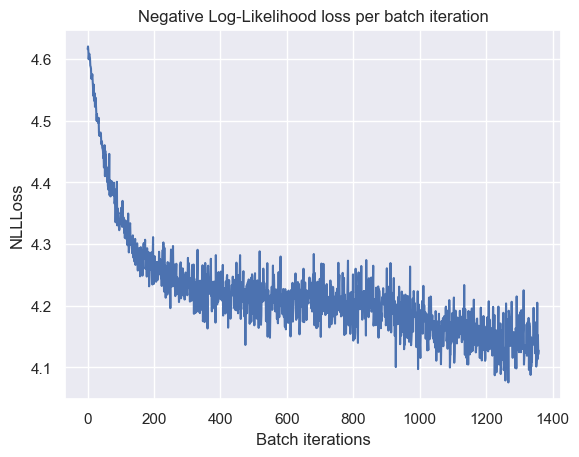

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.plot(batch_losses)
plt.title("Negative Log-Likelihood loss per batch iteration")
plt.xlabel("Batch iterations")
plt.ylabel("NLLLoss")
# plt.savefig("./images/small_mdp_loss_lg_emb.pdf",format="pdf", bbox_inches="tight")

Next will be the behaviour of our net in term of difference of frobenius norm. This can help us do a relatively easy comparative between this approach and others like sGS_ADMM_MDPs

Text(0, 0.5, '$\\sum_{a \\in \\mathcal{A}}||X_a - M_a||_{fb}$')

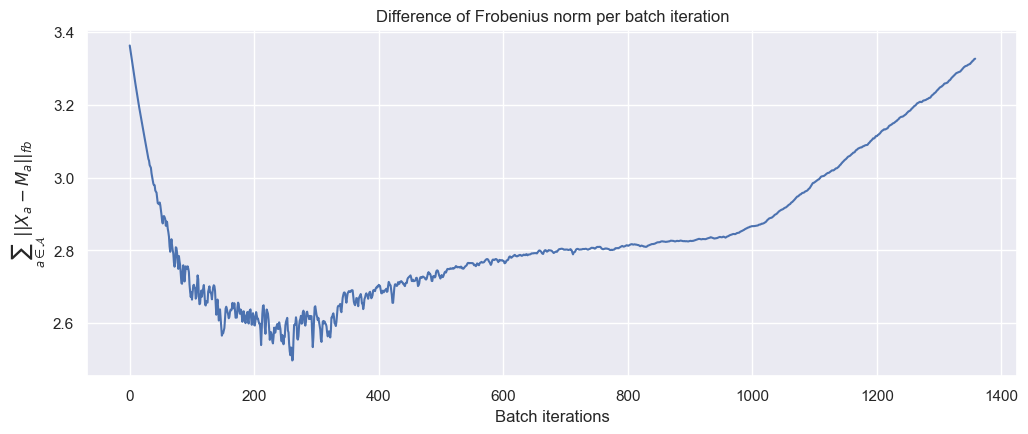

In [15]:
# frob_diff_batch = [i for i in frob_diff for j in range(5)]
plt.figure(figsize=(12, 4.5))
plt.plot(frob_diff)
plt.title("Difference of Frobenius norm per batch iteration")
plt.xlabel("Batch iterations")
plt.ylabel("$\sum_{a \in \mathcal{A}}||X_a - M_a||_{fb}$")
# plt.savefig("./images/small_mdp_fb_diff_lg_emb.pdf",format="pdf", bbox_inches="tight")

In [19]:
m0 = net.phi_a_matrix(torch.tensor(0)).detach().unsqueeze(0).to("cpu")
for i in range(1, MDP.A):
    ma = net.phi_a_matrix(torch.tensor(0)).detach().unsqueeze(0).to("cpu")
    m0 = torch.cat((m0, ma), dim=0)
m0.size()

torch.Size([10, 100, 100])

In [20]:
m0_real = torch.from_numpy(MDP.get_transitions())
m0_real.size()

100%|██████████| 10/10 [00:00<00:00, 4995.60it/s]


torch.Size([10, 100, 100])

In [21]:
torch.norm((m0-m0_real))

tensor(3.4184, dtype=torch.float64)

In [40]:
other =  SimplexEnvironment(states=100, actions=10, bell_rank=3)
t_other = torch.from_numpy(other.get_transitions())
torch.norm((t-t_other))

100%|██████████| 10/10 [00:00<00:00, 9984.06it/s]


tensor(4.8705, dtype=torch.float64)

torch.norm((t-t_other))

In [12]:
st = torch.tensor([i for i in range(MDP.S) for j in range(MDP.A)])
acts = torch.tensor(list(range(MDP.A))*MDP.S)

In [16]:
x = ''
with torch.no_grad():
    x = net.phi(st, acts).detach().to("cpu").view(MDP.S, -1, MDP.d).numpy()

In [17]:
x.shape

(100, 10, 3)

In [18]:
from utils import SimplexPlanner
planner = SimplexPlanner(MDP.S, MDP.A, net.d, x)

In [21]:
planner.polices

[array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int64),
 array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64),
 array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [137]:
MDP.P.shape

(100, 10, 3)

In [49]:
planner.get_action(1)

7

In [129]:
x[..., 1].shape

torch.Size([100, 10])

In [24]:
import numpy as np
np.argmax(MDP.P[..., 0], axis=-1)

array([4, 9, 7, 5, 9, 2, 2, 9, 9, 0, 0, 8, 7, 0, 9, 9, 3, 2, 7, 2, 3, 3,
       5, 9, 7, 0, 6, 6, 8, 7, 1, 4, 1, 7, 1, 2, 4, 5, 8, 1, 1, 3, 0, 6,
       1, 2, 3, 9, 8, 1, 9, 1, 8, 5, 9, 9, 3, 1, 7, 4, 0, 5, 6, 5, 1, 4,
       2, 5, 1, 0, 6, 7, 6, 6, 3, 3, 1, 3, 2, 1, 3, 1, 1, 6, 2, 0, 8, 2,
       2, 7, 8, 8, 7, 2, 4, 2, 9, 7, 0, 2], dtype=int64)

In [30]:
np.argmin(x[...,0], axis=-1)

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int64)

In [111]:
net.phi(torch.tensor([10]),torch.tensor([9]))

tensor([[[0.0767, 0.0821, 0.8412]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [58]:
print(net.phi(torch.tensor([0]),torch.tensor([0])))

tensor([[[1.5668e-02, 1.1168e-05, 9.8432e-01]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [67]:
with torch.no_grad():
    print(net.phi(torch.tensor([1,0]), torch.tensor([1,0])))

tensor([[[1.9843e-03, 1.2494e-05, 9.9800e-01]],

        [[3.1845e-01, 5.6387e-05, 6.8149e-01]]], device='cuda:0')


In [70]:
net.encode_input(torch.tensor([0]),torch.tensor([0]))

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')

In [65]:
s = torch.tensor([1,0])
a = torch.tensor([1,0])
input_len = len(s) if hasattr(s, '__len__') else 1
actions_len = len(a) if hasattr(a, '__len__') else 1
s_hot = F.one_hot(s.view(input_len, 1), net.states).to(torch.float32)
a_hot = F.one_hot(a.view(input_len, 1), net.actions).to(torch.float32)
x = torch.cat((s_hot, a_hot), dim=-1)# Concat one hot vectors 

x

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0

In [63]:
net.encode_input(torch.tensor([1,0]),torch.tensor([1,0])).shape

torch.Size([2, 1, 110])

In [92]:
s = torch.tensor([1,0])
a = torch.tensor([1,0])
x = net.encode_input(s, a) 
x = F.relu(net.l1(x))
x = F.leaky_relu(net.l2(x))
x = net.bn1(x)
# x = net.embedding(x)
x

tensor([[[ 2.0709, -0.8627, -0.8655, -0.8636, -0.8677,  1.0508,  0.6427,
          -0.8610,  2.1643,  1.0005, -0.8658,  0.3544,  1.7129, -0.8606,
          -0.8675, -0.8619, -0.8600, -0.8691,  0.5492, -0.8702]],

        [[ 0.1667, -0.8588, -0.8600, -0.8590, -0.8609, -0.1262, -0.3458,
          -0.8584,  0.3037, -0.1988, -0.8605, -0.4401,  0.0068, -0.8590,
          -0.8614, -0.8587, -0.8578, -0.8614, -0.3321, -0.8612]]],
       device='cuda:0', grad_fn=<CudnnBatchNormBackward0>)

In [91]:
s = torch.tensor([1])
a = torch.tensor([1])
x = net.encode_input(s, a) 
x = F.relu(net.l1(x))
x = F.leaky_relu(net.l2(x))
x = net.bn1(x)
# x = net.embedding(x)
x

tensor([[[ 1.3641, -0.9508, -0.9531, -0.9515, -0.9547,  0.5591,  0.2371,
          -0.9495,  1.4377,  0.5194, -0.9532,  0.0095,  1.0815, -0.9492,
          -0.9546, -0.9502, -0.9487, -0.9559,  0.1633, -0.9568]]],
       device='cuda:0', grad_fn=<CudnnBatchNormBackward0>)

In [17]:
import numpy as np
s = np.array([0,1,2])
a = np.array([0,1])

In [31]:
s1 = np.repeat(s, [6]*3).reshape(3,2,3)
s1

array([[[0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1]],

       [[2, 2, 2],
        [2, 2, 2]]])

In [30]:
a1 = np.tile(np.repeat(a, [len(s)]*len(a)), len(s)).reshape(3,2,3)
a1

array([[[0, 0, 0],
        [1, 1, 1]],

       [[0, 0, 0],
        [1, 1, 1]],

       [[0, 0, 0],
        [1, 1, 1]]])

In [29]:
s2 = np.tile(s, len(s) * len(a)).reshape(3,2,3)
s2

array([[[0, 1, 2],
        [0, 1, 2]],

       [[0, 1, 2],
        [0, 1, 2]],

       [[0, 1, 2],
        [0, 1, 2]]])

In [32]:
def reward(s_prev, a, s_next):
    return np.log(s_prev + 1) + np.log(a + 1) + np.log(s_next + 1)

In [34]:
reward(s1,a1,s2)

array([[[0.        , 0.69314718, 1.09861229],
        [0.69314718, 1.38629436, 1.79175947]],

       [[0.69314718, 1.38629436, 1.79175947],
        [1.38629436, 2.07944154, 2.48490665]],

       [[1.09861229, 1.79175947, 2.19722458],
        [1.79175947, 2.48490665, 2.89037176]]])

In [37]:
np.repeat(np.arange(3), [4,4,4])

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])

In [52]:
x = np.arange(27).reshape(3,3,3)
x

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

In [65]:
x = np.arange(27).reshape(3,3,3)
x = np.sum(x, axis=-1).reshape(3,3, 1)
x

array([[[ 3],
        [12],
        [21]],

       [[30],
        [39],
        [48]],

       [[57],
        [66],
        [75]]])

In [19]:
np.sum(np.arange(9).reshape(3,3), axis=-1)

array([ 3, 12, 21])

In [15]:
import numpy as np
from operator import itemgetter
a = np.arange(3)
d = {0: 0, 1:1, 2: 2}

np.array(itemgetter(*a.tolist())(d))


array([0, 1, 2])

In [17]:
np.tile(a, 3)

array([0, 1, 2, 0, 1, 2, 0, 1, 2])

In [16]:
np.repeat(a, [3]*3)

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

In [20]:
np.eye(6)

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])